In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import torch
import random
import torch.nn as nn
import sklearn
import collections
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import json
from torch.optim import Adam
import pylab
from scipy.optimize import curve_fit
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')
from functions import load_model, save_model, Dataset, mse_loss
from sklearn.metrics import roc_curve, auc

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Load Background data, which will be used for training
filename = 'BKG_dataset.h5'
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)

(640000, 57)


In [3]:
# Define consts
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 20
BATCH_SIZE = 1024

In [4]:
# Initialize datasets
train_dataset = Dataset(X=X_train, y=X_train)
test_dataset = Dataset(X=X_test, y=X_test)
val_dataset = Dataset(X=X_val, y=X_val)

In [5]:
# Initialize dataloaders
train_loader = train_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=True)
test_loader = test_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
val_loader = val_dataset.create_dataloader(batch_size=BATCH_SIZE, shuffle=False)
batch_X, batch_y = next(iter(train_loader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n")

Sample batch:
  X: [1024, 57]
  y: [1024, 57]



/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(sample[0]).float() for sample in batch]
/content/gdrive/MyDrive/Penn/Colab/Data/functions.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = [torch.tensor(sample[1]).float() for sample in batch]


In [6]:
class DNN_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """input_dim: dimension of the input data.
        latent_dim: dimension of the latent space. Should be smaller than all of the other layers.
        num_nodes: two element array containing the number of nodes in the two hidden layers."""
        super(DNN_VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x_in):
        """Forward through the autoencoder with relu activation."""

        # Encoder
        h = F.relu(self.fc1(x_in))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)

        # reparameterize
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps*std

        # Decoder
        h = F.relu(self.fc2(z))
        z = self.fc3(h)
        return z, mean, logvar

    def loss_function(self, x, y, mu, logvar, beta=0.27):
        """Compute the VAE loss. Beta was calculated to be roughly 0.27 for equal
        contribution of mse and kl loss terms."""
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x, y, reduction='mean')

        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = (1 - beta)*recon_loss + beta*kl_loss
        return loss

In [7]:
# Define a class which will handle training and testing the model
class Trainer(object):
    def __init__(self, model, num_batches_avg, loss_fn=None, optimizer=None, scheduler=None):
        """num_batches_avg: Number of batches to calculate the average loss over.
        example: if there are 625 batches, we might want to use 25, to calculate
        average loss over 25 batches."""

        #Set params
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_batches_avg = num_batches_avg

    def train_step(self, dataloader):
        """Train for one epoch.

        returns: average loss over most recent {num_batches_avg} batches, loss over most recent batch
        """

        self.model.train()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0

        # Iterate over batches in dataloader
        for i, batch in enumerate(dataloader):

            # Pass a single batch through the model and update the weights
            inputs, targets = batch
            self.optimizer.zero_grad()
            outputs, mu, logvar = self.model(inputs)
            loss = self.loss_fn(outputs, targets, mu, logvar)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Update loss metrics
            running_loss += loss.item()
            current_loss = loss.item()

            # Calculate the average loss
            if i % self.num_batches_avg == self.num_batches_avg - 1:
                avg_loss = running_loss / self.num_batches_avg
                running_loss = 0.0

        return avg_loss, current_loss

    def eval_step(self, dataloader):
        """validation or test step over one epoch."""

        self.model.eval()
        current_loss = 0.0 # Average loss of most recent batch
        avg_loss = 0.0 # Average loss over a certain number of batches
        running_loss = 0.0
        y_trues, model_outputs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, y_true = batch
                outputs, mu, logvar = self.model(inputs)
                loss = self.loss_fn(outputs, y_true, mu, logvar)

                # Update loss metrics
                running_loss += loss.item()
                current_loss = loss.item()

                # Calculate the average loss
                if i % self.num_batches_avg == self.num_batches_avg - 1:
                    avg_loss = running_loss / self.num_batches_avg
                    running_loss = 0.0

                # Store outputs
                y_trues.extend(y_true)
                model_outputs.extend(outputs)
        return avg_loss, current_loss, np.vstack(y_trues), np.vstack(model_outputs)

    def predict_step(self, dataloader):
        """Prediction step."""
        self.model.eval()
        model_outputs = []

        # Iterate over batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Pass a single batch through the model
                inputs, targets = batch
                outputs, mu , logvar = self.model(inputs)

                # Store outputs
                model_outputs.extend(outputs)

        return np.vstack(model_outputs), np.vstack(mu), np.vstack(logvar)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        """Train the neural net."""

        best_val_loss = np.inf
        patience_counter=patience

        # Loop over epochs
        for epoch in range(num_epochs):

            # Steps
            avg_train_loss, last_train_loss = self.train_step(dataloader=train_dataloader)
            avg_val_loss, last_val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                patience_counter = patience # reset patience
            else:
                patience_counter -= 1
            if not patience_counter: # 0
                print("Stoping Early!")
                break

            # Logging
            print(f'Epoch: {epoch+1} | '
            f'average train loss over most recent {self.num_batches_avg} batches: {avg_train_loss},'
            f'average val loss over most recent {self.num_batches_avg} batches: {avg_val_loss},'
            #f'learning rate: {self.optimizer.param_groups[0]['lr']:.2E},'
            f'patience counter: {patience_counter}')

        return best_model

In [8]:
# Initialize model
INPUT_DIM = X_train.shape[1]
HIDDEN_DIM = 16
LATENT_DIM = 3
dense_VAE = DNN_VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
print(dense_VAE.named_parameters)

<bound method Module.named_parameters of DNN_VAE(
  (fc1): Linear(in_features=57, out_features=16, bias=True)
  (fc_mean): Linear(in_features=16, out_features=3, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=57, bias=True)
)>


In [9]:
# Calculate the appropriate beta value for loss function
# (We want the mse and kl loss terms to be roughly equal contributions)

outputs, mu, logvar = dense_VAE(batch_X)
mse_loss = F.mse_loss(outputs, batch_X, reduction='mean')
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
beta = mse_loss / (kl_loss + mse_loss)
print(f'mse loss: {mse_loss}')
print(f'kl loss: {kl_loss}')
print(f'beta: {beta}')

mse loss: 90.57707214355469
kl loss: 227.4429168701172
beta: 0.2848156690597534


In [9]:
# Initialize the loss function, optimizer and lr scheduler, trainer
def loss_fn(x_in, y, mu, logvar):
    return dense_VAE.loss_function(x_in, y, mu, logvar)
optimizer = Adam(params=dense_VAE.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=3, verbose=True)
trainer = Trainer(model=dense_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [10]:
# Train
best_model = trainer.train(
    num_epochs=NUM_EPOCHS, patience=PATIENCE,
    train_dataloader=train_loader, val_dataloader=val_loader)

Epoch: 1 | average train loss over most recent 25 batches: 10.591544342041015,average val loss over most recent 25 batches: 9.856253471374512,patience counter: 5
Epoch: 2 | average train loss over most recent 25 batches: 6.603471012115478,average val loss over most recent 25 batches: 6.116886768341065,patience counter: 5
Epoch: 3 | average train loss over most recent 25 batches: 4.827001628875732,average val loss over most recent 25 batches: 4.9969283294677735,patience counter: 5
Epoch: 4 | average train loss over most recent 25 batches: 3.7671226024627686,average val loss over most recent 25 batches: 3.7779127025604247,patience counter: 5
Epoch: 5 | average train loss over most recent 25 batches: 3.2668045425415038,average val loss over most recent 25 batches: 3.1881771183013914,patience counter: 5
Epoch: 6 | average train loss over most recent 25 batches: 3.3462941741943357,average val loss over most recent 25 batches: 3.046377000808716,patience counter: 5
Epoch: 7 | average train lo

In [11]:
# Save model
save_model(best_model, 'DNN_VAE_2')

In [12]:
# Load model
dense_VAE = DNN_VAE(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dense_VAE = load_model(dense_VAE, 'DNN_VAE_2')
trainer = Trainer(model=dense_VAE, num_batches_avg=25,
                  loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [32]:
# Calculate the appropriate beta value for loss function
# (We want the mse and kl loss terms to be roughly equal contributions)

outputs, mu, logvar = dense_VAE(batch_X)
mse_loss = F.mse_loss(outputs, batch_X, reduction='mean')
kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


beta = mse_loss / (kl_loss + mse_loss)
print(f'mse loss: {mse_loss}')
print(f'kl loss: {kl_loss}')
print(f'beta: {beta}')

mse loss: 1.7838101387023926
kl loss: 2.63421368598938
beta: 0.4037574529647827


In [13]:
#bkg_prediction, bkg_mu, bkg_logvar = trainer.predict_step(dataloader=test_loader)
bkg_prediction, bkg_mu, bkg_logvar = dense_VAE(torch.tensor(X_test, requires_grad=False).float())
bkg_prediction = bkg_prediction.detach().numpy()

In [14]:
# add correct signal labels
signal_labels = ['Ato4l', 'hChToTauNu', 'hToTauTau', 'leptoquark']

In [15]:
# add correct path to signal files
drive_path = '/content/gdrive/MyDrive/Penn/Colab/Data/'
signals_file = [drive_path+label+'_dataset.h5' for label in signal_labels]
print(signals_file)

['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hChToTauNu_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/hToTauTau_dataset.h5', '/content/gdrive/MyDrive/Penn/Colab/Data/leptoquark_dataset.h5']


In [16]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file[label])
    signal_data.append(test_data)

print(np.array(signal_data).shape)

(4,)


<ipython-input-16-fcddd4288aef>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(signal_data).shape)


In [17]:
signal_results = []
sig_mu = []
sig_logvar = []

for i, label in enumerate(signal_labels):
    signal_prediction, mu, logvar = dense_VAE(torch.tensor(signal_data[i], requires_grad=False).float())
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal
    sig_mu.append(mu)
    sig_logvar.append(logvar)

## KL AD Score

In [22]:
# Define AD score
def AD_score(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

In [23]:
# compute loss value (true, predicted)
total_loss = []

total_loss.append(AD_score(bkg_mu, bkg_logvar).detach())
for i, signal_X in enumerate(signal_data):
    total_loss.append(AD_score(sig_mu[i], sig_logvar[i]).detach())

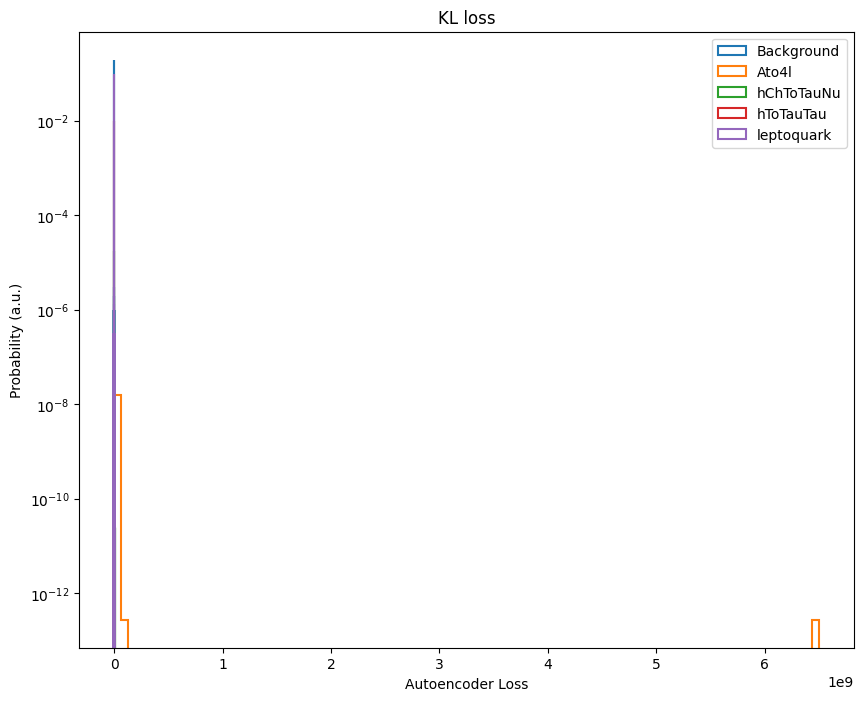

In [25]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('KL loss')
plt.legend(loc='best')
plt.show()

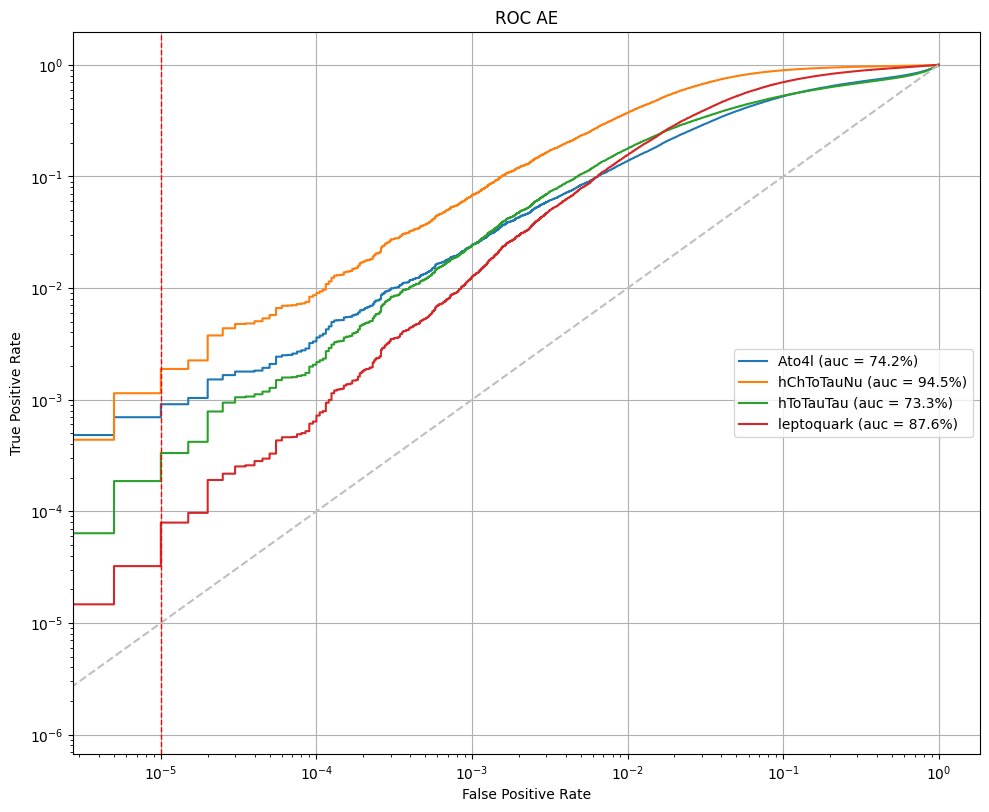

In [26]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE with KL AD Score")
plt.show()

## MSE KL Score

In [29]:
# compute loss value (true, predicted)
total_loss = []

total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X,
                               signal_results[i][2].detach().numpy().astype(np.float32)))

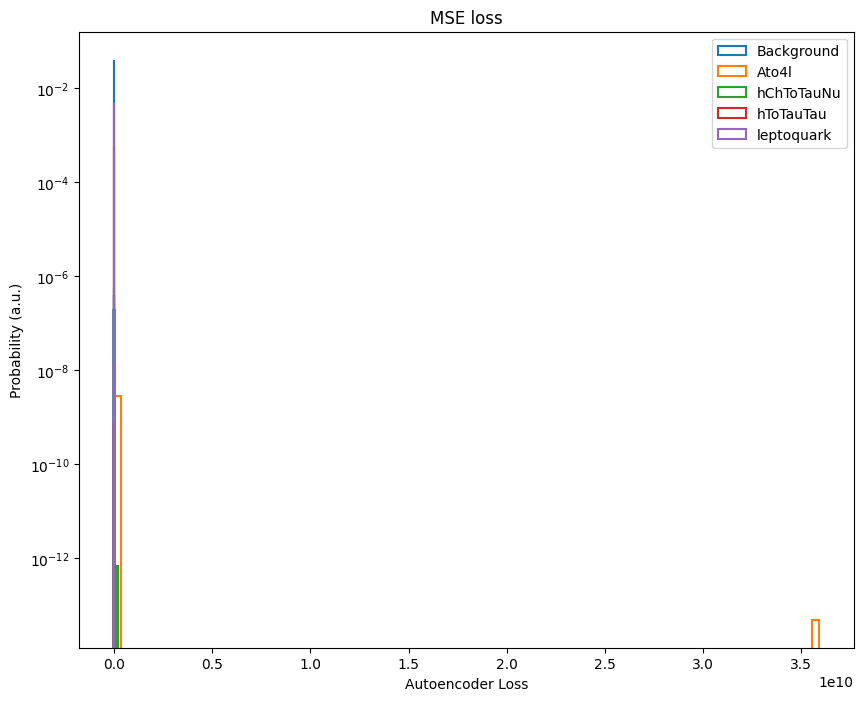

In [30]:
bin_size=100
labels = np.concatenate([['Background'], np.array(signal_labels)])
plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

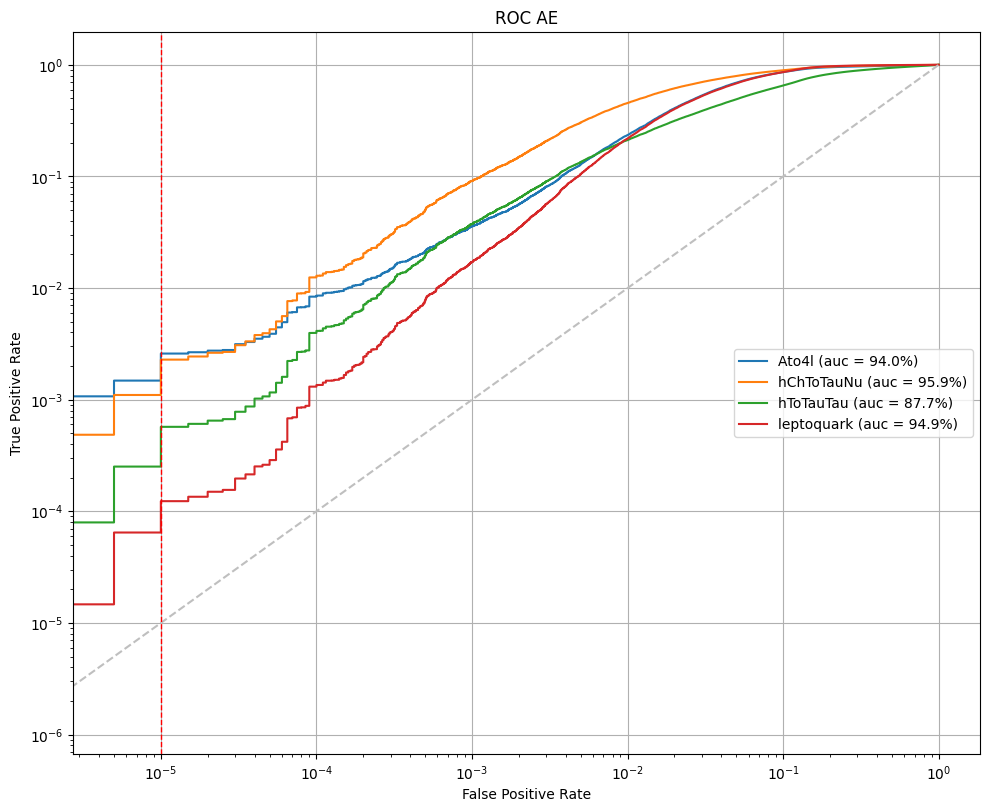

In [31]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE with MSE AD Score")
plt.show()